# MLP Model

**Original paper**
- Word level language model (with 17000 possible words)
- Embeds all the words into a 30 dimensional space (each word has an associated 30 dimensional feature vector)
- Trains these embeddings with backpropagation (they are treated as a parameter of the neural network)
- Trains the network using negative log likelihood loss just like before
- Network structure:
    - Embedding matrix of shape (17000, 30)
    - Tanh layer with 90 inputs (3 words) and `N` outputs
    - Softmax layer with `N` inputs and 17000 outputs

### Setup

In [1]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt

torch.set_printoptions(linewidth=140)


In [2]:
words = open("names.txt", "r").read().splitlines()
print(f"First few words: {words[:5]}\nNumber of words: {len(words)}")

First few words: ['emma', 'olivia', 'ava', 'isabella', 'sophia']
Number of words: 32033


In [3]:
chars = ["."] + sorted(set("".join(words)))
char_to_ix = {s: i for i, s in enumerate(chars)}
ix_to_char = {i: s for s, i in char_to_ix.items()}

### Creating the training dataset

In [4]:
block_size = 3
X, Y = [], []

for word in words[:5]: # just 5 for now
    padded_word = ["."] * block_size + list(word) + ["."]
    for i in range(len(padded_word)-block_size):
        context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
        target = char_to_ix[padded_word[i+block_size]]
        X.append(context), Y.append(target)

X, Y = torch.tensor(X), torch.tensor(Y)
print(f"{X.shape=}\t{X.dtype=}\n{Y.shape=}\t{Y.dtype=}")

X.shape=torch.Size([32, 3])	X.dtype=torch.int64
Y.shape=torch.Size([32])	Y.dtype=torch.int64


### Building the network piece by piece
- Each of the 27 characters will be embedded in a 2 dimensional space
- Pass the concatenated embeddings of the context into a hidden layer
- Pass the output of the hidden layer into an output layer that outputs logits
    - Pass the logits into a softmax layer to get the probability distributions for prediction
    - Use the logits and the targets to compute the cross entropy loss for training

**Technical tips:**
- Matrix multiplication with one-hot-encoding is the same as indexing
- PyTorch indexing is very flexible
- Unbinding and concatinating can be done more efficiently with view (see this [pytorch internals blog post](http://blog.ezyang.com/2019/05/pytorch-internals/) for more details)
- View and reshape are very similar (reshape calls view when possible)
- Be careful when broadcasting (allign the dimensions from the right and check if its doing what you want it to do)
- Using builtin pytorch cross-entropy loss function is computationally faster and more numerically stable

In [5]:
print(f"{X.shape=}\n{Y.shape=}") # this is our training sample (with batch dimension of 32)

X.shape=torch.Size([32, 3])
Y.shape=torch.Size([32])


In [6]:
embedding_size = 2
C = torch.randn((len(chars), embedding_size)) # this is the embedding matrix
print(f"{C.shape=}")

C.shape=torch.Size([27, 2])


In [7]:
emb = C[X] # this is the embedded training data
print(f"{emb.shape=}")

emb.shape=torch.Size([32, 3, 2])


In [8]:
h_in = emb.view(-1, block_size*embedding_size) # this is what we will pass to the hidden layer
print(f"{h_in.shape=}")

h_in.shape=torch.Size([32, 6])


In [9]:
hidden_layer_size = 100
W1 = torch.randn((block_size*embedding_size, hidden_layer_size))
b1 = torch.randn(hidden_layer_size)
print(f"{W1.shape=}\n{b1.shape=}")

W1.shape=torch.Size([6, 100])
b1.shape=torch.Size([100])


In [10]:
h_out = torch.tanh(h_in @ W1 + b1) # hidden layer output (be careful when broadcasting)
print(f"{h_out.shape=}")

h_out.shape=torch.Size([32, 100])


In [11]:
W2 = torch.randn((hidden_layer_size, len(chars)))
b2 = torch.randn((len(chars)))
print(f"{W2.shape=}\n{b2.shape=}")

W2.shape=torch.Size([100, 27])
b2.shape=torch.Size([27])


In [12]:
logits = h_out @ W2 + b2 # output of the neural network
print(f"{logits.shape=}")

logits.shape=torch.Size([32, 27])


In [13]:
probs = torch.softmax(logits, dim=1)
print(f"{probs.shape=}")

probs.shape=torch.Size([32, 27])


In [14]:
loss = F.cross_entropy(logits, Y)
loss

tensor(19.7805)

In [15]:
probs = logits.exp() / logits.exp().sum(dim=1, keepdims=True)
loss = -probs[torch.arange(32), Y].log().mean()
loss

tensor(19.7805)

### Putting everything together
- Minibatches speed up training since it reduces the number of computations for each training step. 
- However, the gradient direction for a minibatch may be different from the gradient direction of the complete training-set. 
- We can update the parameters according to the gradient of the minibatch and this should be similar to the gradient of the entire training set on average. This is known as **stochastic gradient descent**.

In [16]:
block_size = 3
embedding_size = 2
hidden_layer_size = 100

In [17]:
X, Y = [], []

for word in words:
    padded_word = ["."] * block_size + list(word) + ["."]
    for i in range(len(padded_word)-block_size):
        context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
        target = char_to_ix[padded_word[i+block_size]]
        X.append(context), Y.append(target)

X, Y = torch.tensor(X), torch.tensor(Y)
print(f"{X.shape=}\t{X.dtype=}\n{Y.shape=}\t{Y.dtype=}")

X.shape=torch.Size([228146, 3])	X.dtype=torch.int64
Y.shape=torch.Size([228146])	Y.dtype=torch.int64


In [18]:
# initialize parameters
g = torch.Generator().manual_seed(5)
C = torch.randn((len(chars), embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((block_size*embedding_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, len(chars)), requires_grad=True, generator=g)
b2 = torch.randn((len(chars)), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

In [19]:
for step in range(100):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,)) # 32 random indices from the training-set
    
    # forward pass
    emb = C[X[ix]]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data -= 0.1 * p.grad
    
    # print
    print(f"{step}:\t{loss.item()}")

0:	16.043237686157227
1:	12.213603973388672
2:	11.371526718139648
3:	12.366456985473633
4:	12.38438606262207
5:	9.539551734924316
6:	10.788346290588379
7:	10.159205436706543
8:	8.514666557312012
9:	9.346335411071777
10:	7.975589752197266
11:	9.973198890686035
12:	8.773650169372559
13:	7.185835361480713
14:	5.91326904296875
15:	8.310028076171875
16:	10.363814353942871
17:	6.830173969268799
18:	5.900486946105957
19:	5.637796878814697
20:	6.246935844421387
21:	6.839103698730469
22:	6.669023036956787
23:	6.678976058959961
24:	6.45774507522583
25:	7.875441074371338
26:	5.096419334411621
27:	6.563788890838623
28:	7.150516033172607
29:	5.417165279388428
30:	5.453258514404297
31:	6.345064163208008
32:	5.528562545776367
33:	5.7843017578125
34:	5.994226455688477
35:	6.867105007171631
36:	5.612514019012451
37:	3.848315477371216
38:	4.725233554840088
39:	4.490649700164795
40:	4.890439510345459
41:	6.004271984100342
42:	5.233211994171143
43:	4.633263111114502
44:	5.289414882659912
45:	4.59115648269

### Finding a good learning rate
**Step 1:** Find a reasonable search range
- Try a bunch of learning rates (at different orders of magnitude) and find a reasonable search range
    - The lower bound should be something that decreases the loss but not too quikly
    - The highigher should be something that causes the loss to be unstable or even explode
- In this case we got `0.001` as the lower bound and `0.1` as the upper bound

**Step 2:** Iterate through the network with exponentially increasing learning rates from within the search range and keep track of the loss. Graph the learning rate vs the loss and see where it starts to become unstable. A good learning rate is just before that.

In [20]:
# initialize parameters
g = torch.Generator().manual_seed(5)
C = torch.randn((len(chars), embedding_size), requires_grad=True, generator=g)
W1 = torch.randn((block_size*embedding_size, hidden_layer_size), requires_grad=True, generator=g)
b1 = torch.randn(hidden_layer_size, requires_grad=True, generator=g)
W2 = torch.randn((hidden_layer_size, len(chars)), requires_grad=True, generator=g)
b2 = torch.randn((len(chars)), requires_grad=True, generator=g)
parameters = [C, W1, b1, W2, b2]

# candidate learning rates that we want to search over
lrs = torch.logspace(start=-3, end=0, steps=1000) # or use `torch.logspace`

loss_i = []
for i in range(len(lrs)):
    
    # minibatch construct
    ix = torch.randint(0, X.shape[0], (32,))
    
    # forward pass
    emb = C[X[ix]]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data -= lrs[i] * p.grad
    
    # track stats
    loss_i.append(loss.item())

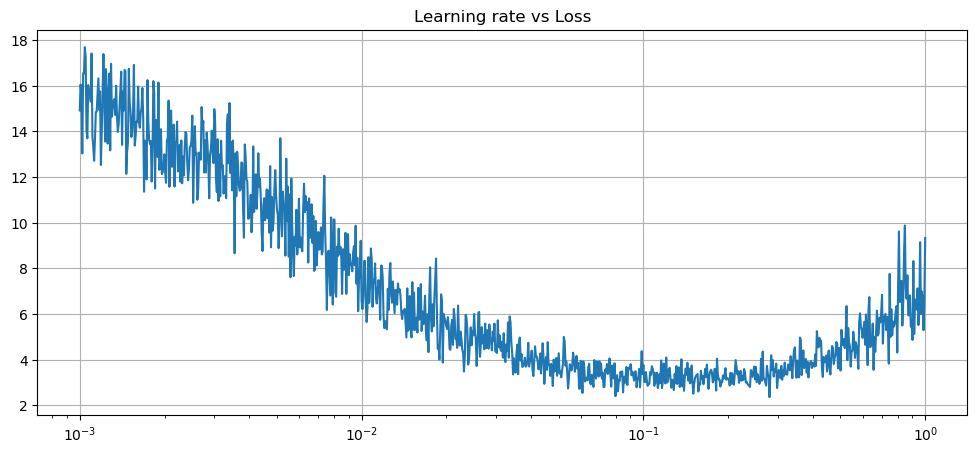

In [21]:
plt.figure(figsize=(12,5)); plt.title("Learning rate vs Loss"); plt.plot(lrs, loss_i); plt.grid(); plt.xscale("log");

A good learning rate turns out to be near `0.1`

### Train-val-test split
- Neural network models can get very large with many parameters. As the capacity of the network grows, it becomes more an more capable of **overfitting** (i.e. memorising the dataset).
- The solution is to split up the data into the training split, dev/validation split, and the test split
    - The **training split** is used to **optimize the parameters** of the model
    - The **dev/validation** split is used for **development over the hyperparameters** (e.g size of the embedding, strength of regularization, etc.)
    - The **test split** is used to **evaluate the performance** (therefore you should only evaluate the loss on the test set sparingly)
- A common ratio for splitting the data `80:10:10`

In [22]:
def build_dataset(words, block_size=3, verbose=False):
    X, Y = [], []
    for word in words:
        padded_word = ["."] * block_size + list(word) + ["."]
        for i in range(len(padded_word)-block_size):
            context = [char_to_ix[char] for char in padded_word[i:i+block_size]]
            target = char_to_ix[padded_word[i+block_size]]
            X.append(context), Y.append(target)
    X, Y = torch.tensor(X), torch.tensor(Y)
    if verbose:
        print(f"{X.shape}\t{Y.shape}")
    return X, Y

In [23]:
import random; random.seed(5)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

X_tr, Y_tr = build_dataset(words[:n1], verbose=True)
X_dev, Y_dev = build_dataset(words[n1:n2], verbose=True)
X_te, Y_te = build_dataset(words[n2:], verbose=True)

torch.Size([182558, 3])	torch.Size([182558])
torch.Size([22712, 3])	torch.Size([22712])
torch.Size([22876, 3])	torch.Size([22876])


### Training for longer
**Tip:** Lower the learning rate by `10x` during the late stages of training, this is known as **learning rate decay**

In [24]:
for step in range(30_000):
    
    # minibatch construct
    ix = torch.randint(0, X_tr.shape[0], (32,)) # 32 random indices from the training-set
    
    # forward pass
    emb = C[X_tr[ix]]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y_tr[ix])
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    for p in parameters:
        p.data -= 0.1 * p.grad # start with 0.1 and move to 0.01 after some time

In [25]:
def evaluate(X, Y):
    emb = C[X]
    h_in = emb.view(-1, block_size*embedding_size)
    h_out = torch.tanh(h_in @ W1 + b1)
    logits = h_out @ W2 + b2
    loss = F.cross_entropy(logits, Y)
    return loss.item()

In [26]:
evaluate(X_tr, Y_tr)
evaluate(X_dev, Y_dev)

2.3836560249328613

### Visualizing 2-dimensional embeddings

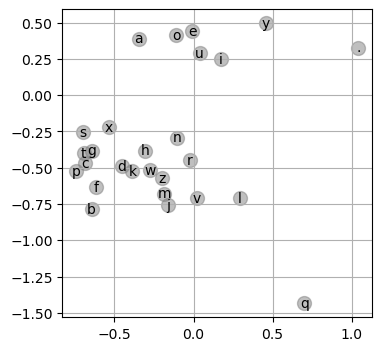

In [27]:
plt.figure(figsize=(4, 4))
plt.scatter(C[:,0].data, C[:,1].data, s=100, color='gray', alpha=0.5)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), ix_to_char[i], ha="center", va="center", color='black')
plt.grid('minor')

### Sampling from the model

In [28]:
g = torch.Generator().manual_seed(5)

for _ in range(20):
    context = ["."] * block_size
    out = []
    while True:
        emb = C[torch.tensor([char_to_ix[char] for char in context])]
        h_in = emb.view(-1, block_size * embedding_size)
        h_out = torch.tanh(h_in @ W1 + b1)
        logits = h_out @ W2 + b2
        probs = F.softmax(logits, dim=1)

        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        if ix==0:
            break
        char = ix_to_char[ix]
        context = context[1:] + [char]
        out.append(char)
    print("".join(out), end="\t")

kariu	dipalau	sha	gamio	maih	brili	dafp	konien	misioa	medan	ducin	arnseestufsicheranyl	noy	kiod	coshit	aaseta	rlisianto	galy	prgt	zatginittynessinreha	